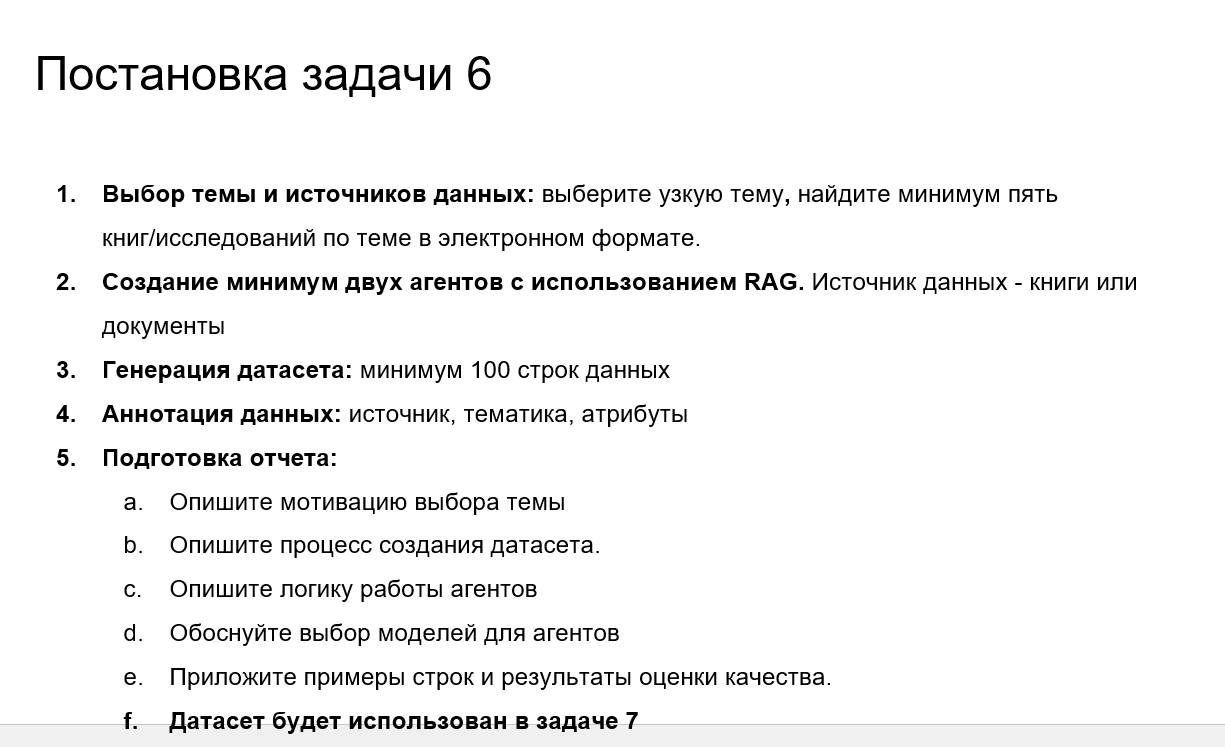

а) Сначала я хотел выбрать тему авиации, но не нашел нормальных книг в формате pdf, поэтому мне пришла в голову мысль взять различные работы по политике Дэн Сяопина в КНР. Взял, потому что есть небольшие статьи на эту тему и нашел даже ВКР бакалавра. Также это достаточно узкая тема, в которой недообученная llm вряд ли разбирается.\
б) Добавил мои pdf файлы в colab, разделил их на чанки, сделал эмбеддинги и создал векторную базу данных, потом надо было использовать агентов для задавания вопросов и получаения ответов, но ОЗУ говорит пока-прощай, поэтому colab постоянно вылетал из-за этого, а локально если делать, то у меня оперативки меньше на ноутбуке, поэтому задание оказалось в плане технической реализации очень сложным

In [11]:
!pip -q install langchain
!pip -q install sentence-transformers
!pip -q install faiss-gpu
!pip -q install pypdf

In [12]:
!pip install -U langchain-community

In [13]:
import os
import re
from pprint import pprint
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import LLMChain
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [14]:
dir='/content/sample_data'
documents = []
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith(".pdf"):
            print(f'root={root} file={file}')
            loader = PyPDFLoader(os.path.join(root, file))
            documents.extend(loader.load())

root=/content/sample_data file=issn_1997-292X_2018_2_02.pdf
root=/content/sample_data file=vneshnepoliticheskaya-strategiya-den-syaopina-v-period-ekonomicheskih-reform-i-otkrytosti-konets-1970-h-1990-e-gg.pdf
root=/content/sample_data file=Omurova.pdf
root=/content/sample_data file=osnovnye-printsipy-i-suschnost-reform-den-syaopina.pdf
root=/content/sample_data file=den-syaopin.pdf


In [15]:
print(type(documents))
print(len(documents))
print(documents[20].metadata)
print(documents[20].page_content)

<class 'list'>
32
{'source': '/content/sample_data/Omurova.pdf', 'page': 0}
Вестник КРСУ. 2014. Том 14. № 6185Б.Н. Омурова  
УДК 323.22/.28(510)
РЕФОРМЫ ДЭН СЯОПИНА И ИХ ЗНАЧЕНИЕ  
В ИСТОРИИ СОВРЕМЕННОГО КИТАЯ
Б.Н. Омурова
Проведен анализ реформ Дэн Сяопина и их влияния на дальнейшее развитие Китая.
Ключевые слова: Китай; Дэн Сяопин; реформы; модернизация.
DEN XIAOPING’S REFORMS AND THEIR SIGNIFICANCE  
IN THE HISTORY OF THE MODERN CHINA
B.N. Omurova
The author makes analysis of Den Xiaoping’s reforms and of their impact on the further development of China.
Key words: China; Den Xiaoping; reforms; modernization.
В результате политической борьбы, развер -
нувшейся после смерти Мао Цзэдуна в 1976 г.,  
к власти пришли прагматично настроенные люди, 
придерживающиеся собственных позиций в во -
просе будущего развития государства. Они были 
крепко убеждены в том, что для решения эконо -
мических проблем необходимо провести крупно -
масштабные преобразования. Так было положено 
начало модерн

In [16]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=0)
source_chunks = text_splitter.split_documents(documents)
print(type(source_chunks))
print(len(source_chunks))
print(source_chunks[100].metadata)
print(source_chunks[100].page_content)

<class 'list'>
130
{'source': '/content/sample_data/osnovnye-printsipy-i-suschnost-reform-den-syaopina.pdf', 'page': 1}
ляет  общественная  собственность  на  средства  
производства , при  этом  поощряется  развитие  не-
социалистических  секторов  экономики , включая  
частный  сектор . Дэн  Сяопин  отказался  от  буква-
листского  противопоставления  плана  и рынка , 
рассматривая  и то , и другое  лишь  как  средства  в 
руках  государства , не  определяющие  его  сущ-
ность  ( поскольку  при  социализме , также  как  и 
при  капитализме , используется  и план , и рынок ) 
и в период  реформ  80-90-х гг. руководство  КПК  
постепенно  через  ряд  промежуточных  этапов ,


In [17]:
model_id = 'intfloat/multilingual-e5-large'
model_kwargs = {'device': 'cuda'}
embeddings = HuggingFaceEmbeddings(
  model_name=model_id,
  model_kwargs=model_kwargs
)

In [18]:
db = FAISS.from_documents(source_chunks, embeddings)

In [19]:
topic = 'социализм с китайской спецификой'
docs = db.similarity_search(topic, k = 3)
message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\n#### {i+1} Relevant chunk ####\n' + str(doc.metadata) + '\n' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
print(message_content)


#### 1 Relevant chunk ####
{'source': '/content/sample_data/osnovnye-printsipy-i-suschnost-reform-den-syaopina.pdf', 'page': 1}
ния  основной  части  общественного  богатства  в 
руках  малой  части  общества . Но  социализм  в 
Китае  строился  с учетом  национальной  специ-
фики , заключающейся  в исторически  сложив-
шейся  и объективно  обусловленной  социально -
экономической  отсталости , в условиях  дефицита  
пахотной  земли  и других  необходимых  ресурсов  
для  обеспечения  нормальных  условий  жизни  и 
развития  страны  с миллиардным  населением . 
Поэтому  с начала  разработки  стратегии  модер-
низации  Дэн  Сяопин  отказался  от  догматическо -
го  следования  принятым  в СССР  канонам  социа-
листического  строительства  и вел  поиск  строи-
тельства  собственной  модели  социализма  с ки-
тайской  спецификой . Учитывая , что  преодоление  
отсталости  Китая  потребует  длительного  време-
ни , было  принято  принципиально  теоретическое  
положение  о том , что  КНР 

In [20]:
import csv
import os

faiss_dir = '/content/sample_data/faiss_db'

if not os.path.exists(faiss_dir):
    os.makedirs(faiss_dir)

csv_file_path = os.path.join(faiss_dir, 'faiss_documents.csv')

with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csv_file:
    fieldnames = ['page_number', 'source', 'page_content']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()

    for doc in source_chunks:
        writer.writerow({
            'page_number': doc.metadata.get('page_number', 'N/A'),
            'source': doc.metadata.get('source', 'N/A'),
            'page_content': doc.page_content
        })

print(f"Documents saved to {csv_file_path}")

Documents saved to /content/sample_data/faiss_db/faiss_documents.csv


In [10]:
!pip install -q transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
import torch

model_name = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

pipeline_kwargs = {
    "max_length": 512,
    "max_new_tokens": 256,
}

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    **pipeline_kwargs,
)

llm = HuggingFacePipeline(pipeline=pipeline)


На этом этапе возникает мое любимое сообщение 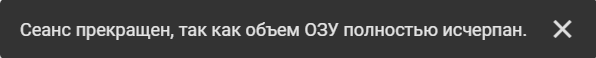

In [ ]:
prompt_template = """
Ты помощник, который помогает найти информацию из базы данных PDF-файлов.
Пользовательский запрос: {query}
Результаты поиска: {results}
Пожалуйста, обобщите результаты и дайте краткий ответ на основе информации из базы данных.
"""

In [ ]:
prompt = PromptTemplate(template=prompt_template, input_variables=["query", "results"])


In [ ]:
llm_chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
def query_agent(query, k=3):
    docs = db.similarity_search(query, k=k)

    results_text = re.sub(
        r'\n{2}', ' ',
        '\n '.join([f'\n#### {i+1} Relevant chunk ####\n' + str(doc.metadata) + '\n' + doc.page_content + '\n'
                    for i, doc in enumerate(docs)])
    )

    answer = llm_chain.run({"query": query, "results": results_text})

    return answer


In [ ]:
topic = 'социализм с китайской спецификой'
answer = query_agent(topic)
print("Ответ агента:", answer)

In [ ]:
import csv
import re

def create_qa_dataset(chunks, llm_chain, file_path='qa_dataset.csv'):
    with open(file_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Question', 'Answer'])

        for i, chunk in enumerate(chunks):
            question_prompt = f"На основе следующего фрагмента текста сформулируйте информативный вопрос:\n\n{chunk.page_content}\n"
            question = llm_chain.run({"query": question_prompt, "results": ''})

            answer_prompt = f"Пожалуйста, ответьте на следующий вопрос, используя предоставленный контекст:\n\n{chunk.page_content}\nВопрос: {question}\n"
            answer = llm_chain.run({"query": answer_prompt, "results": ''})

            question = question.strip()
            answer = answer.strip()

            writer.writerow([question, answer])
            print(f"Вопрос и ответ {i+1} записаны.")

    print(f"Датасет успешно создан и сохранен в {file_path}")

create_qa_dataset(source_chunks, llm_chain)